# Independent Project
Spring 2025

Student: Aró Berg Jónasar\
Supervisor: Christoph Lohrmann

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("python", sys.version)

python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


In [3]:
df = pd.read_csv("data/Malicious URL v3.csv", index_col=0)

In [4]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.describe()

,url,type
count,49750,49750
unique,40439,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,15,36419


There are some duplicates, check if there are duplicate URLs with different class

In [7]:
exact_duplicates = df[df.duplicated(keep=False)].count()
print(f"Exact duplicates: {exact_duplicates.url}")

url_duplicates = df[df.duplicated(subset=['url'], keep=False)].count()
print(f"URL duplicates: {url_duplicates.url}")

Exact duplicates: 18378
URL duplicates: 18378


All the duplicates are exact duplicates (URL and type). Let's remove them.

In [8]:
df = df.drop_duplicates()
df.describe()

,url,type
count,40439,40439
unique,40439,4
top,itunes.apple.com/us/album/fairies-in-the-moonl...,benign
freq,1,29854


Check for missing values

In [9]:
missing_values = df.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
url     0
type    0
dtype: int64


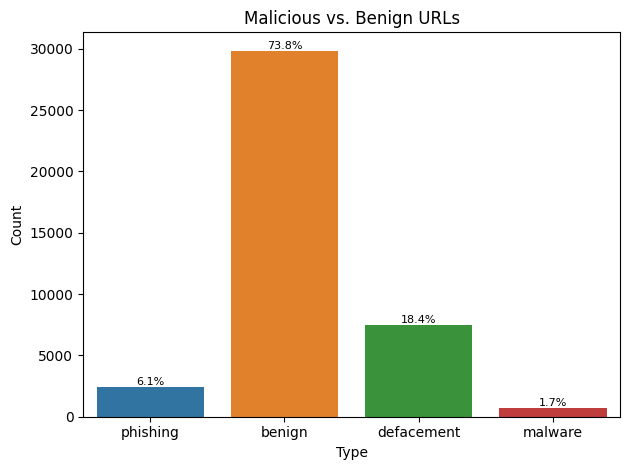

In [ ]:
sns.countplot(data=df, x='type', hue='type')
plt.title('Malicious vs. Benign URLs')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
# write percentages on top of bars
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height() / len(df) * 100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=8, color='black')
plt.show()

### Feature Extraction & Exploration

In [11]:
df['url_length'] = df['url'].apply(len)
df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special_chars'] = df['url'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
df['num_words'] = df['url'].apply(lambda x: len(x.split()))
df['has_ip_address'] = df['url'].apply(lambda x: 1 if any(char.isdigit() for char in x) else 0)
df['has_https'] = df['url'].apply(lambda x: 1 if 'https://' in x else 0)
df['entropy'] = df['url'].apply(lambda x: -sum((x.count(c) / len(x)) * np.log2(x.count(c) / len(x)) for c in set(x)))
df['num_subdomains'] = df['url'].apply(lambda x: x.count('.') - 1 if '.' in x else 0)

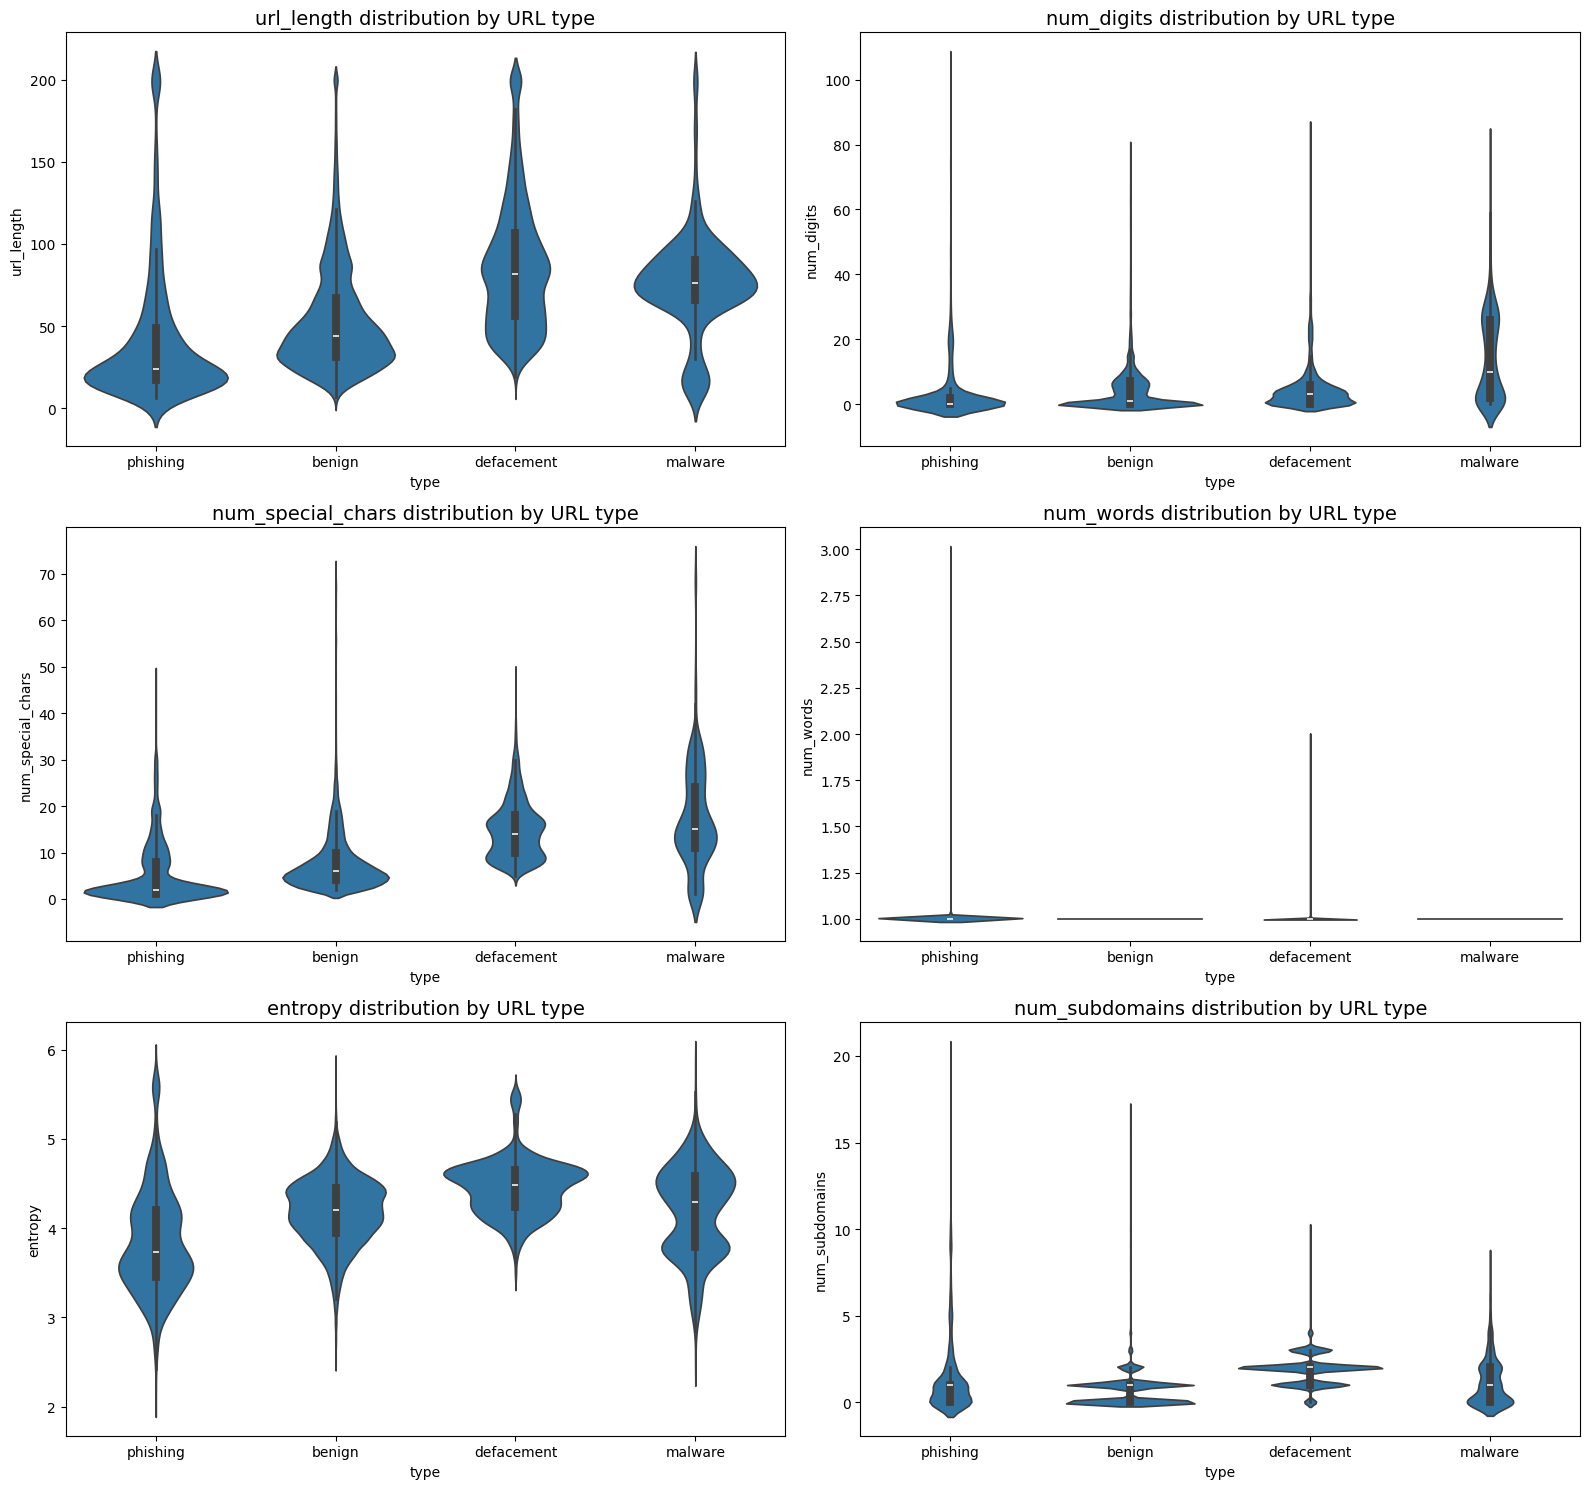

In [39]:
features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove boolean features that are not numerical
features.remove('has_ip_address')
features.remove('has_https')

num_features = len(features)
rows = (num_features + 1) // 2  

fig, axes = plt.subplots(rows, 2, figsize=(16, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(x='type', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} distribution by URL type', fontsize=14)

plt.tight_layout()
plt.show()


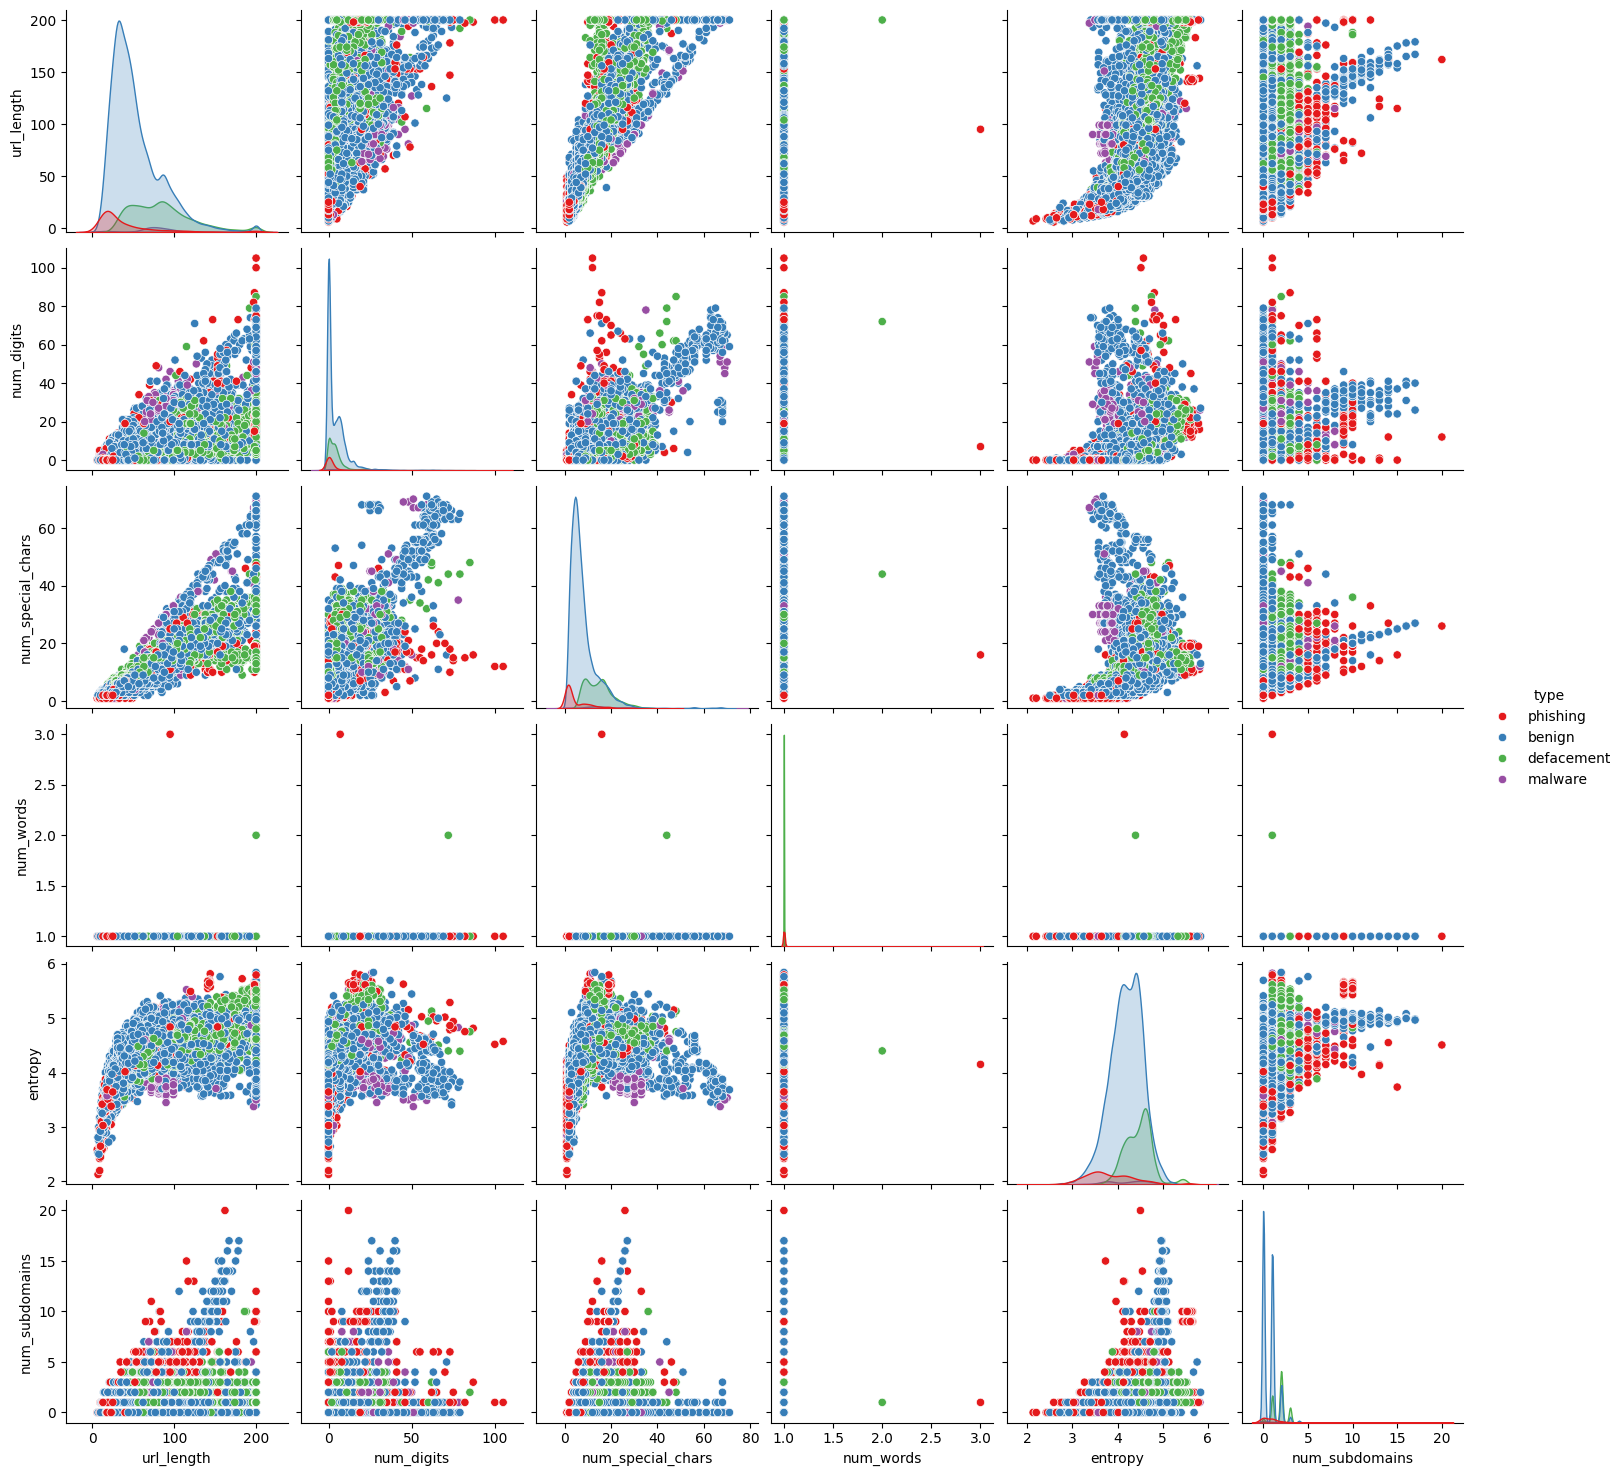

In [40]:
sns.pairplot(df, hue='type', vars=features, diag_kind='kde', palette="Set1")
plt.show()

Since Naive Bayes likes low correlation between features - plot a heatmap of correlations

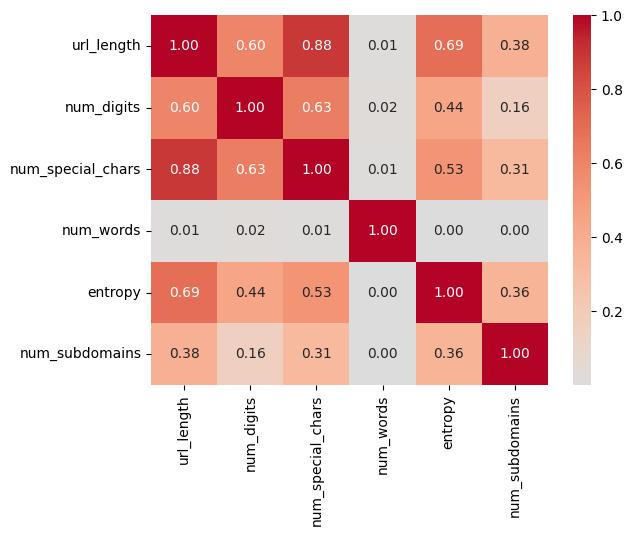

In [41]:
sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

The dataset is heavily imbalanced. Let's group together the malicious URLs into a single class, and make it a binary classification problem.

In [42]:
df['label'] = df['type'].replace(['phishing', 'defacement', 'malware'], 'malicious')
df.head()

,url,type,url_length,num_digits,num_special_chars,num_words,has_ip_address,has_https,entropy,num_subdomains,label
0,br-icloud.com.br,phishing,16,0,3,1,0,0,3.375000,1,malicious
1,mp3raid.com/music/krizz_kaliko.html,benign,35,1,5,1,1,0,4.079143,1,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,1,5,1,1,0,3.708093,1,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,7,18,1,1,0,4.660343,2,malicious
4,http://adventure-nicaragua.net/index.php?optio...,defacement,200,18,14,1,1,0,5.376194,1,malicious


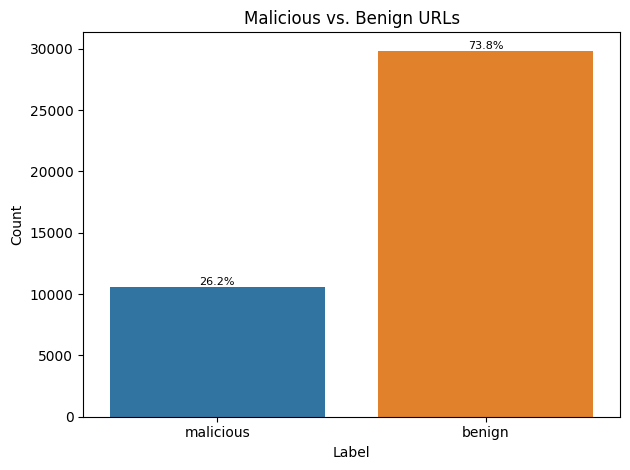

In [43]:
sns.countplot(data=df, x='label', hue='label')
plt.title('Malicious vs. Benign URLs')
plt.xlabel('Label')
plt.ylabel('Count')

# write percentages on top of bars
for p in plt.gca().patches:
    plt.annotate(f'{p.get_height() / len(df) * 100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=8, color='black')
plt.tight_layout()
plt.show()

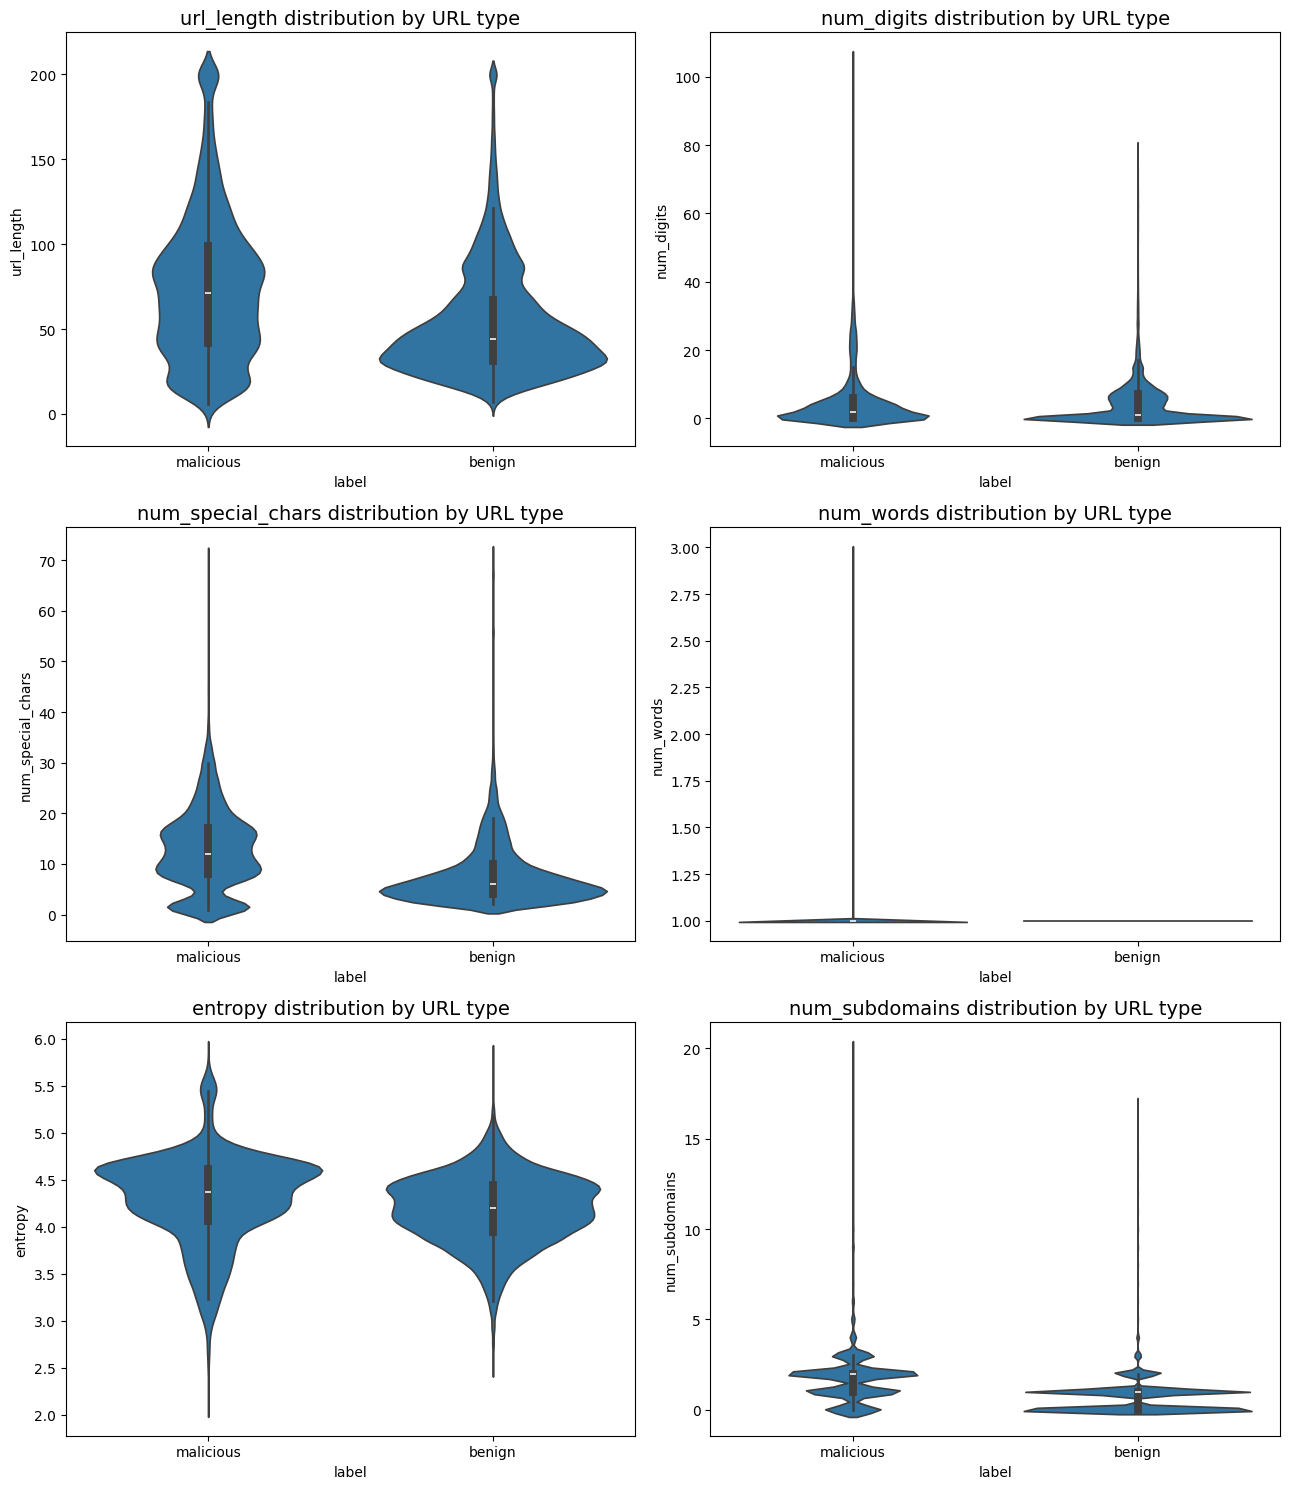

In [52]:
features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove boolean features that are not numerical
features.remove('has_ip_address')
features.remove('has_https')

num_features = len(features)
rows = (num_features + 1) // 2 

fig, axes = plt.subplots(rows, 2, figsize=(13, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(x='label', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} distribution by URL type', fontsize=14)

plt.tight_layout()
plt.show()

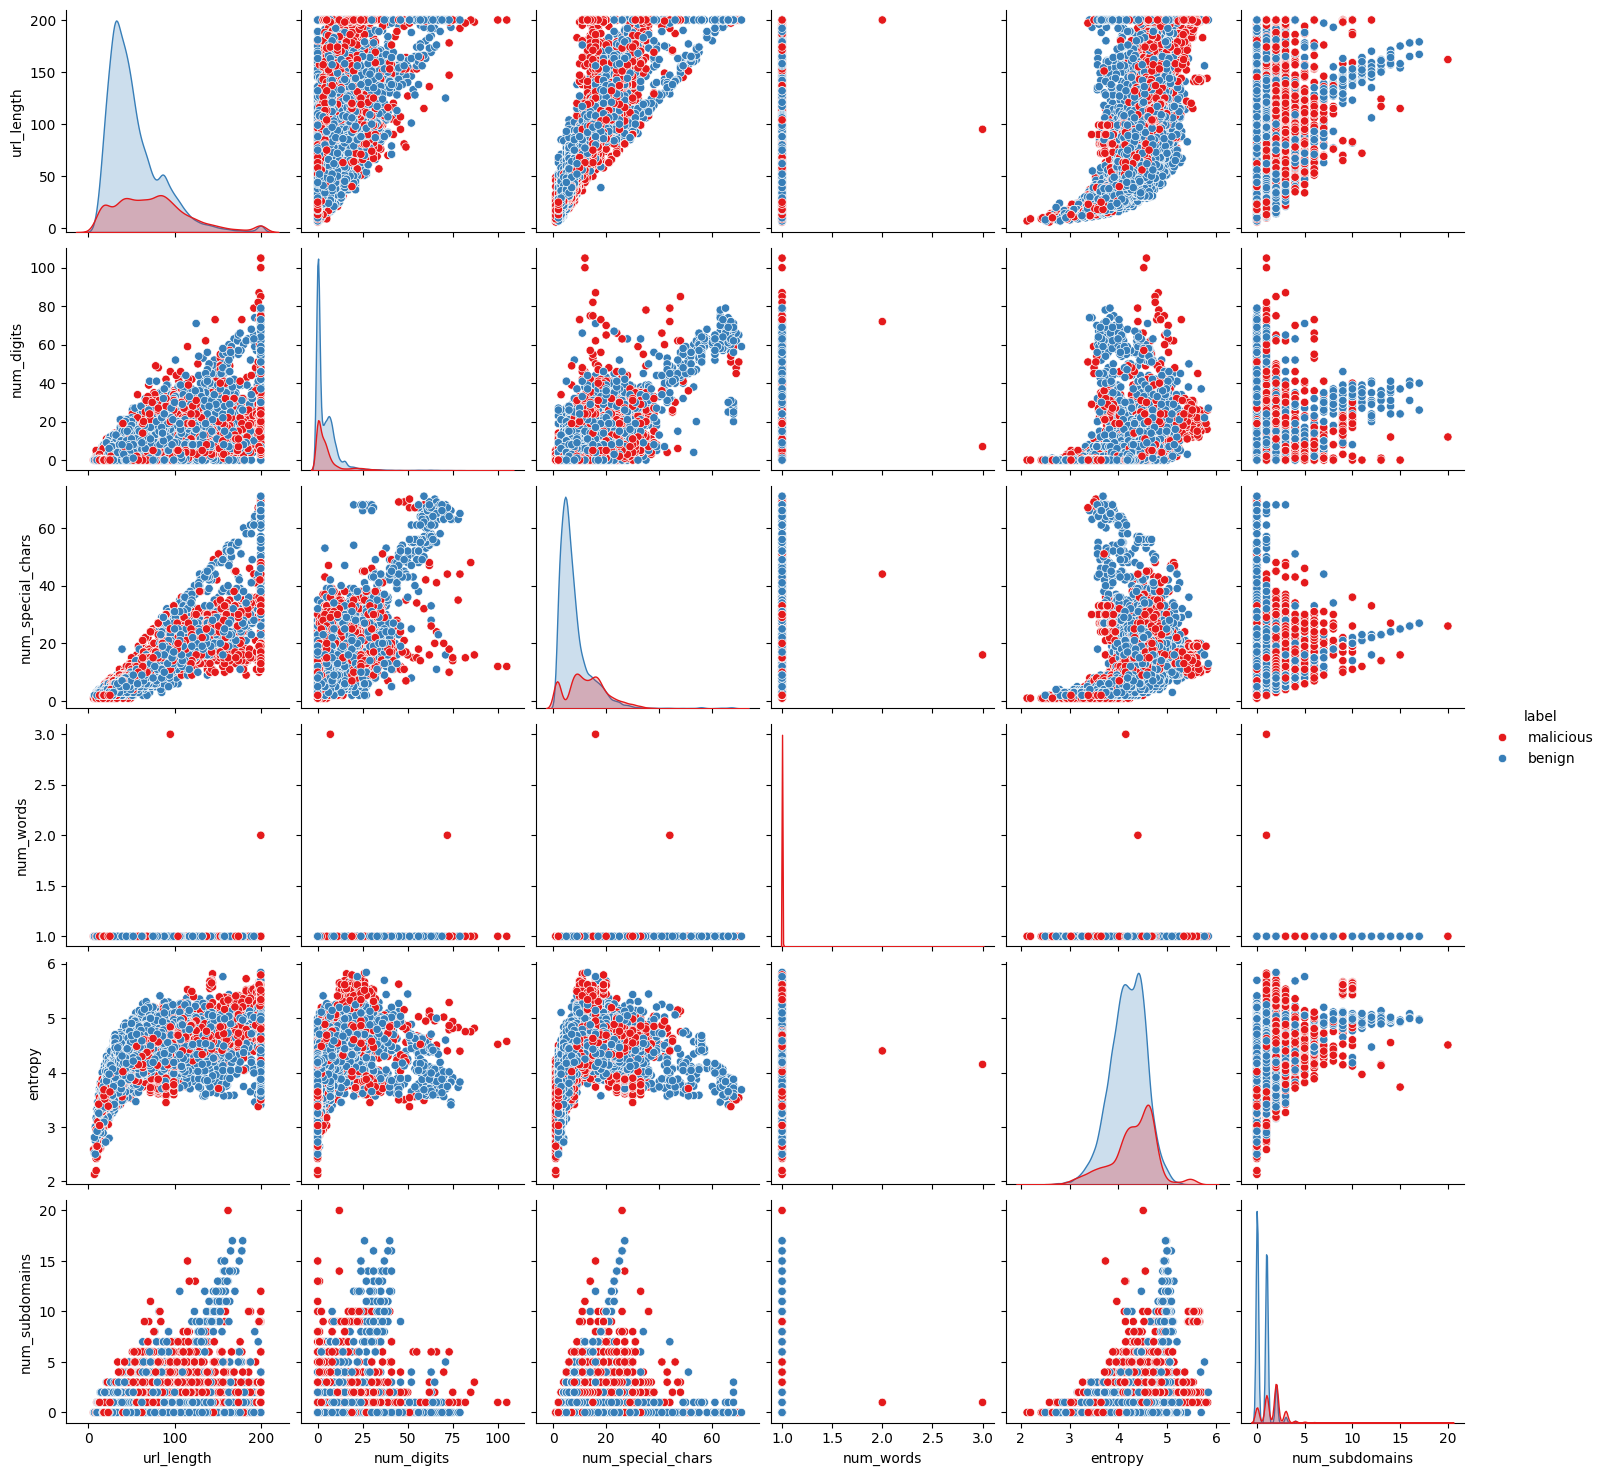

In [53]:
sns.pairplot(df, hue='label', vars=features, diag_kind='kde', palette="Set1")
plt.show()